In [1]:
# ==========================
# Imports: análisis, visualización y modelos
# ==========================
# Librerías principales
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: particionado, modelos y utilidades
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Modelos externos (XGBoost, LightGBM)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression

# Métricas
from sklearn.metrics import accuracy_score, classification_report

# Nota: importar sólo lo que se usa facilita mantenimiento y evita sobrecarga.


## Imports y propósito

Esta sección importa las librerías necesarias para el análisis, visualización y modelado:

- `pandas` para manipulación de datos.
- `matplotlib` y `seaborn` para visualizaciones.
- `scikit-learn` para particionado, validación cruzada y modelos básicos.
- `xgboost` y `lightgbm` para modelos potentes basados en boosting.

Mantener los imports agrupados y documentados ayuda a entender dependencias y a reproducir el entorno.

In [2]:
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
from xgboost import XGBClassifier

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [6]:
# ==========================
# Helper functions: información y normalización de columnas
# ==========================

def show_data_info(data: pd.DataFrame):
    """Imprime información útil del DataFrame para inspección inicial.

    - info(): tipos y NAs
    - head(): primeras filas
    - describe(): resumen estadístico de columnas numéricas
    """
    print("Data Information:")
    print(data.info())
    print("\nFirst 5 Rows of the Data:")
    print(data.head())
    print("\nStatistical Summary of the Data:")
    print(data.describe())


def normalize_column_names(data: pd.DataFrame) -> pd.DataFrame:
    """Normaliza nombres de columnas a snake_case y sin espacios.

    Esto ayuda a evitar errores al referenciar columnas por nombre.
    """
    data = data.copy()
    data.columns = [col.strip().lower().replace(' ', '_') for col in data.columns]
    return data


## Helpers: inspección y normalización

Estas funciones ayudan a inspeccionar rápidamente un DataFrame (`show_data_info`) y a normalizar nombres de columnas (`normalize_column_names`).

Úsalas antes de aplicar la limpieza para verificar tipado, NAs y formato de columnas.

In [7]:
df = normalize_column_names(df)
show_data_info(df)
df_test = normalize_column_names(df_test)

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

First 5 Rows of the Data:
   passengerid  survived  pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5

In [8]:
def clean_data(df: pd.DataFrame, is_train: bool = True) -> pd.DataFrame:
    """Aplica limpieza y feature engineering centralizado al DataFrame.

    Pasos principales:
    1. Normaliza nombres de columnas.
    2. Trata la columna `cabin`: indicador, conteo y tipo.
    3. Codifica `sex` y crea `is_child`.
    4. Extrae `title` desde `name` y agrupa títulos raros.
    5. Imputa `age` por mediana por grupo (sex, pclass, title) y luego global.
    6. Crea `family_size`.
    7. Codifica `embarked` con dummies (drop_first=True).
    8. Para test, asegura imputación de `fare` si falta.

    Notas importantes:
    - Evitar fugas de datos (data leakage): en producción deberías fit/learn
      las estadísticas (p. ej. medianas) sobre el conjunto de entrenamiento
      y aplicarlas al test. Aquí aplicamos una estrategia práctica para análisis.
    - La función es idempotente: puedes llamarla varias veces sin romper el DF.
    """
    df = df.copy()

    # Normalizar nombres de columnas (seguro y idempotente)
    df = normalize_column_names(df)

    # --------------------
    # Cabin: indicador, conteo
    # --------------------
    if 'cabin' in df.columns:
        # Indicador binario si existe cabin
        df['has_cabin'] = df['cabin'].notnull().astype(int)
        # Llenar valores faltantes con 'Unknown' para preservar info textual
        df['cabin'] = df['cabin'].fillna('Unknown')
        # Número de cabinas (al separar por espacio), 0 si 'Unknown'
        df['number_cabin'] = df['cabin'].apply(lambda x: 0 if (not isinstance(x, str) or x == 'Unknown') else len(x.split(' ')))
    else:
        df['has_cabin'] = 0
        df['number_cabin'] = 0
        df['cabin'] = 'Unknown'

    # --------------------
    # Embarked: one-hot encoding
    # --------------------
    if 'embarked' in df.columns:
        df = pd.get_dummies(df, columns=['embarked'], drop_first=True)

    # --------------------
    # Sex -> numeric
    # --------------------
    if 'sex' in df.columns:
        df['sex'] = df['sex'].map({'male': 0, 'female': 1})

    # --------------------
    # Edad: features y imputación
    # --------------------
    if 'age' in df.columns:
        df['is_child'] = (df['age'] < 12).astype(int)
        # age_not_known: 1 cuando falta age
        df['age_not_known'] = df['age'].isnull().astype(int)

    # --------------------
    # Title extraction
    # --------------------
    df = df.reset_index(drop=True)
    if 'name' in df.columns:
        df['title'] = df['name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
        rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Capt']
        df['title'] = df['title'].replace(rare_titles, 'Rare')
    else:
        df['title'] = 'Unknown'

    # Imputar age por grupos (sex,pclass,title) y fallback a mediana global
    if 'age' in df.columns:
        try:
            df['age'] = df['age'].fillna(df.groupby(['sex', 'pclass', 'title'])['age'].transform('median'))
        except Exception:
            # Si no existen las columnas de agrupación, nos quedamos con la mediana global
            pass
        df['age'] = df['age'].fillna(df['age'].median())

    # --------------------
    # Family size
    # --------------------
    if {'sibsp', 'parch'}.issubset(df.columns):
        df['family_size'] = df['sibsp'] + df['parch'] + 1
    else:
        df['family_size'] = 1

    # --------------------
    # Type cabin: extraer letra y mapear a entero (robusto)
    # --------------------
    mapping = {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'T':8,'0':0}
    if 'cabin' in df.columns:
        letters = df['cabin'].astype(str).str.extract(r'([A-Za-z])', expand=False).str.upper()
        df['type_cabin'] = letters.map(mapping).fillna(0).astype(int)
    else:
        df['type_cabin'] = 0

    # Para el conjunto test, asegurarnos de imputar fare si falta
    if not is_train and 'fare' in df.columns:
        df['fare'] = df['fare'].fillna(df['fare'].median())

    return df


## Función `clean_data`

Esta celda define `clean_data`, la función centralizada que aplica todas las transformaciones de limpieza y feature engineering. Mantén la función como punto único de mantenimiento para reglas de imputación y creación de nuevas variables.

In [9]:
def find_missing_values(df: pd.DataFrame, name: str = 'data', top_n: int = None) -> pd.DataFrame:
    """Devuelve un DataFrame con columnas, conteos y porcentajes de valores faltantes.

    Uso:
        missing = find_missing_values(df, name='df')
        print(missing)
    """
    total = len(df)
    missing_counts = df.isnull().sum()
    missing_pct = (missing_counts / total) * 100
    missing_df = pd.DataFrame({
        'column': missing_counts.index,
        'missing_count': missing_counts.values,
        'missing_pct': missing_pct.values
    })
    missing_df = missing_df[missing_df['missing_count'] > 0].sort_values('missing_count', ascending=False).reset_index(drop=True)
    if top_n is not None:
        missing_df = missing_df.head(top_n)
    return missing_df

# Ejemplo de uso:
# missing_test = find_missing_values(df_test)
# print(missing_test)


## Auditoría de valores faltantes

`find_missing_values` es una función pequeña que devuelve un DataFrame con el conteo y porcentaje de valores faltantes por columna. Úsala antes y después de `clean_data` para comprobar el efecto de las imputaciones.

In [10]:
# ===============================================
# LIMPIEZA BÁSICA DE DATOS Y FORMATO
# Se centraliza la limpieza mediante `clean_data` y se auditan NAs con `find_missing_values`.
# ===============================================

print("=== INFORMACIÓN INICIAL DEL DATASET ===")
print(f"Forma del dataset: {df.shape}")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")

# 1. REVISAR VALORES FALTANTES (antes de limpiar)
print("\n=== VALORES FALTANTES EN TEST (antes) ===")
print(find_missing_values(df_test))

# 2. Aplicar limpieza centralizada
df = clean_data(df, is_train=True)
df_test = clean_data(df_test, is_train=False)

# 3. Revisar valores faltantes (después de limpiar)
print("\n=== VALORES FALTANTES EN TEST (después) ===")
print(find_missing_values(df_test))
print("\n=== VALORES FALTANTES EN TRAIN (después) ===")
print(find_missing_values(df))

# Mostrar una muestra para inspección
show_data_info(df_test)


=== INFORMACIÓN INICIAL DEL DATASET ===
Forma del dataset: (891, 12)
Número de filas: 891
Número de columnas: 12

=== VALORES FALTANTES EN TEST (antes) ===
  column  missing_count  missing_pct
0  cabin            327    78.229665
1    age             86    20.574163
2   fare              1     0.239234

=== VALORES FALTANTES EN TEST (después) ===
Empty DataFrame
Columns: [column, missing_count, missing_pct]
Index: []

=== VALORES FALTANTES EN TRAIN (después) ===
Empty DataFrame
Columns: [column, missing_count, missing_pct]
Index: []
Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   passengerid    418 non-null    int64  
 1   pclass         418 non-null    int64  
 2   name           418 non-null    object 
 3   sex            418 non-null    int64  
 4   age            418 non-null    float64
 5   sibsp          418 non-nu

## Limpieza y comprobaciones

En esta sección:

- Comprobamos valores faltantes antes de la limpieza.
- Aplicamos `clean_data` a `df` y `df_test`.
- Volvemos a auditar valores faltantes y mostramos una muestra del dataset limpio.

In [11]:
# Aplicar limpieza reproducible centralizada
# La función `clean_data` realiza normalización de columnas, imputaciones y creación de features.
df = clean_data(df, is_train=True)
# Aplicar limpieza reproducible al conjunto de test
df_test = clean_data(df_test, is_train=False)

# Mostrar información del dataset de test
show_data_info(df_test)

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   passengerid    418 non-null    int64  
 1   pclass         418 non-null    int64  
 2   name           418 non-null    object 
 3   sex            0 non-null      float64
 4   age            418 non-null    float64
 5   sibsp          418 non-null    int64  
 6   parch          418 non-null    int64  
 7   ticket         418 non-null    object 
 8   fare           418 non-null    float64
 9   cabin          418 non-null    object 
 10  has_cabin      418 non-null    int64  
 11  number_cabin   418 non-null    int64  
 12  embarked_q     418 non-null    bool   
 13  embarked_s     418 non-null    bool   
 14  is_child       418 non-null    int64  
 15  age_not_known  418 non-null    int64  
 16  title          418 non-null    object 
 17  family_size    418 non-null    int64

In [12]:
# Search for missing values again after cleaning
# Writing all in english
print("\n=== Values missing after cleaning in TEST ===")
print(find_missing_values(df_test, name='df_test'))


=== Values missing after cleaning in TEST ===
  column  missing_count  missing_pct
0    sex            418        100.0


In [13]:
#Code Ad hoc for the missing values in the test set
print(df_test[df_test['type_cabin'].isnull()].head())

Empty DataFrame
Columns: [passengerid, pclass, name, sex, age, sibsp, parch, ticket, fare, cabin, has_cabin, number_cabin, embarked_q, embarked_s, is_child, age_not_known, title, family_size, type_cabin]
Index: []


In [14]:
#Check Bad data
print("\n=== REVISIÓN DE DATOS INCORRECTOS O ATÍPICOS ===")
print("Revisando la columna 'age' para valores negativos o mayores a 100:")
# Search a data with values less than 0 or greater than 100
bad_data_age = df[(df['age'] < 0) | (df['age'] > 100)]
print(bad_data_age)



=== REVISIÓN DE DATOS INCORRECTOS O ATÍPICOS ===
Revisando la columna 'age' para valores negativos o mayores a 100:
Empty DataFrame
Columns: [passengerid, survived, pclass, name, sex, age, sibsp, parch, ticket, fare, cabin, has_cabin, number_cabin, embarked_q, embarked_s, is_child, age_not_known, title, family_size, type_cabin]
Index: []


In [15]:
def check_is_negative(data: pd.DataFrame, column: str) -> bool:
    """Check for negative values in a specified column of the DataFrame."""
    bad_data = data[data[column] < 0]
    # If there are negative values, return True
    return bad_data.shape[0] > 0

def check_is_greater_than(data: pd.DataFrame, column: str, value: int) -> bool:
    """Check for values greater than a specified value in a specified column of the DataFrame."""
    bad_data = data[data[column] > value]
    return bad_data.shape[0] > 0

def normaliza_gender(data: pd.DataFrame, column: str) -> pd.DataFrame:
    data[column] = data[column].str.lower()
    return data

In [16]:
# Must be check the Male/Female grammar
if  0 < len(df['sex'].unique()) > 2:
  print("#Error in the sex")

if check_is_negative(df, 'age'):
  print("Error: There are negative values in the 'age' column.")
show_data_info(df)


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   passengerid    891 non-null    int64  
 1   survived       891 non-null    int64  
 2   pclass         891 non-null    int64  
 3   name           891 non-null    object 
 4   sex            0 non-null      float64
 5   age            891 non-null    float64
 6   sibsp          891 non-null    int64  
 7   parch          891 non-null    int64  
 8   ticket         891 non-null    object 
 9   fare           891 non-null    float64
 10  cabin          891 non-null    object 
 11  has_cabin      891 non-null    int64  
 12  number_cabin   891 non-null    int64  
 13  embarked_q     891 non-null    bool   
 14  embarked_s     891 non-null    bool   
 15  is_child       891 non-null    int64  
 16  age_not_known  891 non-null    int64  
 17  title          891 non-null    objec

In [17]:
print(df_test.info())
print(df_test.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   passengerid    418 non-null    int64  
 1   pclass         418 non-null    int64  
 2   name           418 non-null    object 
 3   sex            0 non-null      float64
 4   age            418 non-null    float64
 5   sibsp          418 non-null    int64  
 6   parch          418 non-null    int64  
 7   ticket         418 non-null    object 
 8   fare           418 non-null    float64
 9   cabin          418 non-null    object 
 10  has_cabin      418 non-null    int64  
 11  number_cabin   418 non-null    int64  
 12  embarked_q     418 non-null    bool   
 13  embarked_s     418 non-null    bool   
 14  is_child       418 non-null    int64  
 15  age_not_known  418 non-null    int64  
 16  title          418 non-null    object 
 17  family_size    418 non-null    int64  
 18  type_cabin

In [18]:
# Convertir / asegurar algunas transformaciones ya realizadas en clean_data
# Nota: la mayoría de estas transformaciones ya las hace `clean_data`. Aquí sólo corregimos pequeñas inconsistencias
# Asegurarse de que `age_not_known` tiene la semántica correcta (1 si falta edad)
if 'age' in df.columns:
    df['age_not_known'] = df['age'].isnull().astype(int)

if 'age' in df_test.columns:
    df_test['age_not_known'] = df_test['age'].isnull().astype(int)

# Reiniciar índices (ya lo hace clean_data, pero por seguridad)
df = df.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Crear copia limpia para modelado
df_clean = df.copy()
df_clean_test = df_test.copy()

In [19]:
print(df_test['type_cabin'].value_counts())
# Buscar los valores NULL
print(df_test['type_cabin'].isnull().sum())
#Imprimit los 10 valores primero faltantates
print(df_test[df_test['type_cabin'].isnull()].head(10))
print("   \n ")
print(df_test.head(10))

type_cabin
0    327
3     35
2     18
4     13
5      9
6      8
1      7
7      1
Name: count, dtype: int64
0
Empty DataFrame
Columns: [passengerid, pclass, name, sex, age, sibsp, parch, ticket, fare, cabin, has_cabin, number_cabin, embarked_q, embarked_s, is_child, age_not_known, title, family_size, type_cabin]
Index: []
   
 
   passengerid  pclass                                          name  sex  \
0          892       3                              Kelly, Mr. James  NaN   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  NaN   
2          894       2                     Myles, Mr. Thomas Francis  NaN   
3          895       3                              Wirz, Mr. Albert  NaN   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  NaN   
5          897       3                    Svensson, Mr. Johan Cervin  NaN   
6          898       3                          Connolly, Miss. Kate  NaN   
7          899       2                  Caldwell, Mr.

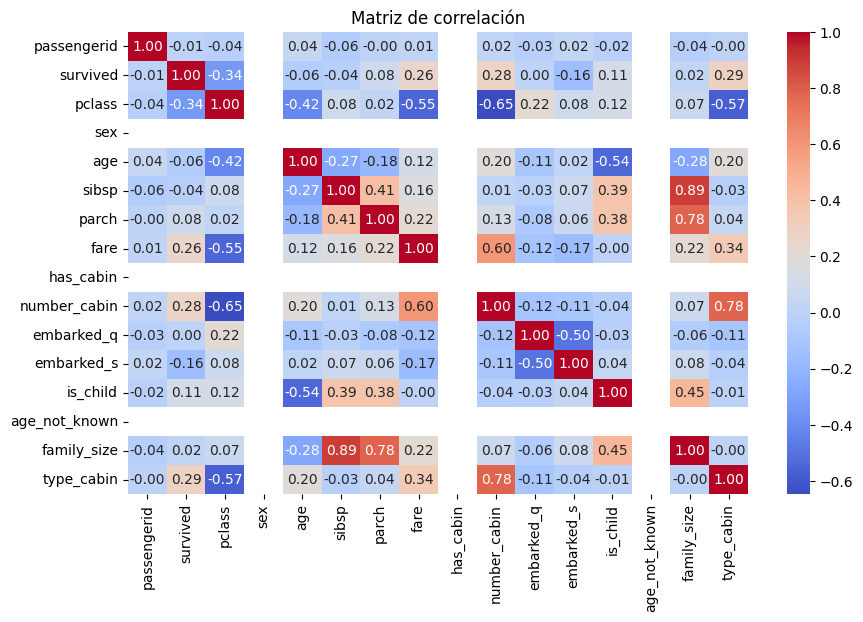

In [20]:
# Calculate the matrix of correlation
corr = df.corr(numeric_only=True)  # must ensure to use only numeric columns

# Viewalize in heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

In [21]:
print( df.groupby(['sex','pclass','title'])['age'].describe())

Empty DataFrame
Columns: []
Index: []


In [22]:
print(find_missing_values(df, name='df'))

  column  missing_count  missing_pct
0    sex            891        100.0


In [23]:
df_clean = df.copy()
df_clean_test = df_test.copy()

In [24]:
print(df_clean.describe())

       passengerid    survived      pclass  sex         age       sibsp  \
count   891.000000  891.000000  891.000000  0.0  891.000000  891.000000   
mean    446.000000    0.383838    2.308642  NaN   29.150584    0.523008   
std     257.353842    0.486592    0.836071  NaN   13.504989    1.102743   
min       1.000000    0.000000    1.000000  NaN    0.420000    0.000000   
25%     223.500000    0.000000    2.000000  NaN   21.000000    0.000000   
50%     446.000000    0.000000    3.000000  NaN   26.000000    0.000000   
75%     668.500000    1.000000    3.000000  NaN   36.750000    1.000000   
max     891.000000    1.000000    3.000000  NaN   80.000000    8.000000   

            parch        fare  has_cabin  number_cabin    is_child  \
count  891.000000  891.000000      891.0    891.000000  891.000000   
mean     0.381594   32.204208        1.0      0.267116    0.080808   
std      0.806057   49.693429        0.0      0.547134    0.272693   
min      0.000000    0.000000        1.0    

In [25]:
# Variables predictoras (X) y variable objetivo (y)
columns_important = ['sex', 'age', 'fare', 'has_cabin', 'embarked_q', 'embarked_s', 'is_child', 'number_cabin', 'pclass', 'sibsp' ,'parch','age_not_known' ,'family_size']
x = df_clean[columns_important]
y = df_clean['survived']

x_test = df_clean_test[columns_important]
# y_test = df_clean_test['survived']

# Dividir en train y test (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [26]:
# Crear el modelo
tree_clf = DecisionTreeClassifier(
    criterion='gini',      # o 'entropy'
    max_depth=4,           # limitar profundidad (para evitar overfitting)
    random_state=42
)

# Entrenar
tree_clf.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [27]:
y_pred = tree_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Accuracy: 0.7486033519553073

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.72      0.94      0.81       105
           1       0.85      0.47      0.61        74

    accuracy                           0.75       179
   macro avg       0.79      0.71      0.71       179
weighted avg       0.77      0.75      0.73       179

 0.7486033519553073

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.72      0.94      0.81       105
           1       0.85      0.47      0.61        74

    accuracy                           0.75       179
   macro avg       0.79      0.71      0.71       179
weighted avg       0.77      0.75      0.73       179



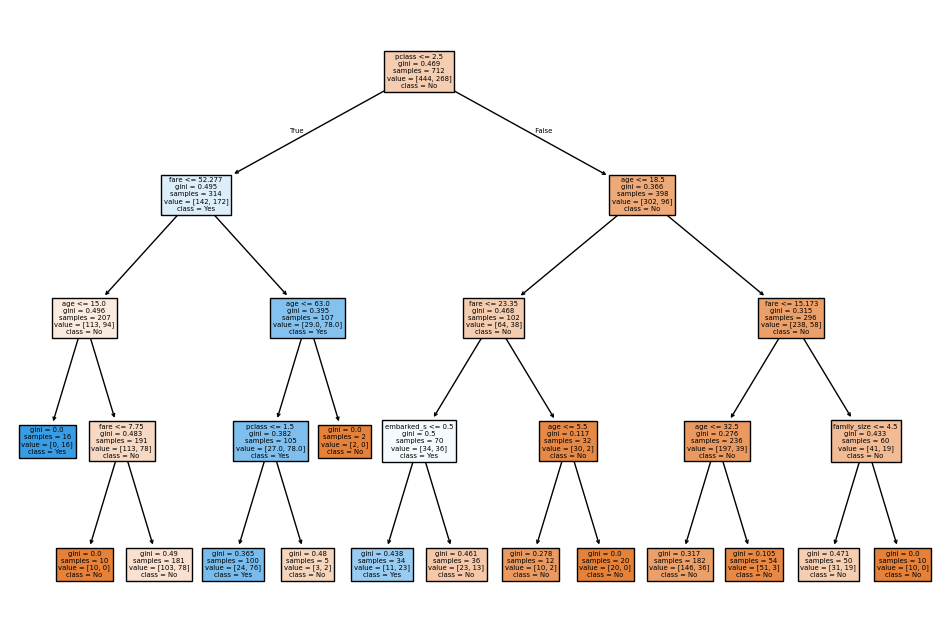

In [28]:
plt.figure(figsize=(12,8))
plot_tree(tree_clf, feature_names=x.columns, class_names=['No', 'Yes'], filled=True)
plt.show()


In [29]:
rf = RandomForestClassifier(n_estimators=300, max_depth=8, max_features='sqrt', random_state=42)
cv = StratifiedKFold(5, shuffle=True, random_state=42)
scores = cross_val_score(rf, x, y, cv=cv, scoring='accuracy')
print(scores.mean())

0.77328479065972


In [30]:
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)
cv = StratifiedKFold(5, shuffle=True, random_state=42)
scores = cross_val_score(gb, x, y, cv=cv, scoring='accuracy')
print(scores.mean())
# Entrenar
gb.fit(X_train, y_train)
# Test model with x_test
y_pred_gb = gb.predict(x_test)
print(y_pred_gb)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\fenic\Kaggle\titanic\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\fenic\Kaggle\titanic\venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\fenic\Kaggle\titanic\venv\Lib\site-packages\sklearn\ensemble\_gb.py", line 658, in fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self,
        ^^^^^
    ...<4 lines>...
        multi_output=True,
        ^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\fenic\Kaggle\titanic\venv\Lib\site-packages\sklearn\utils\validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\fenic\Kaggle\titanic\venv\Lib\site-packages\sklearn\utils\validation.py", line 1368, in check_X_y
    X = check_array(
        X,
    ...<12 lines>...
        input_name="X",
    )
  File "c:\Users\fenic\Kaggle\titanic\venv\Lib\site-packages\sklearn\utils\validation.py", line 1105, in check_array
    _assert_all_finite(
    ~~~~~~~~~~~~~~~~~~^
        array,
        ^^^^^^
    ...<2 lines>...
        allow_nan=ensure_all_finite == "allow-nan",
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\fenic\Kaggle\titanic\venv\Lib\site-packages\sklearn\utils\validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        X,
        ^^
    ...<4 lines>...
        input_name=input_name,
        ^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\fenic\Kaggle\titanic\venv\Lib\site-packages\sklearn\utils\validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
GradientBoostingClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:

xgb = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8, random_state=42)
cv = StratifiedKFold(5, shuffle=True, random_state=42)
scores = cross_val_score(xgb, x, y, cv=cv, scoring='accuracy')
print(scores.mean())


0.8383403427280147


In [ ]:
lgb = LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=31, random_state=42)
cv = StratifiedKFold(5, shuffle=True, random_state=42)
scores = cross_val_score(lgb, x, y, cv=cv, scoring='accuracy')
print(scores.mean())

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [ ]:

lr = LogisticRegression(max_iter=1000)
cv = StratifiedKFold(5, shuffle=True, random_state=42)
scores_l = cross_val_score(lr, X, y, cv=cv, scoring='accuracy')

In [ ]:
print(scores_l.mean())

0.8058565061829137


In [ ]:

LogisticRegression(penalty='l2')  # Ridge
LogisticRegression(penalty='l1')  # Lasso

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [ ]:

svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
cv = StratifiedKFold(5, shuffle=True, random_state=42)
scores_svc = cross_val_score(svm, x, y, cv=cv, scoring='accuracy')
print(scores_svc.mean())

0.6823677107526207


In [ ]:
# Test 
print("=== TEST ===")
# Con el mejor modelo 
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)
cv = StratifiedKFold(5, shuffle=True, random_state=42)

scores = cross_val_score(gb, X, y, cv=cv, scoring='accuracy')
print(scores.mean())

0.8058565061829137
